<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install httpx

     |████████████████████████████████| 84 kB 1.0 MB/s 
     |████████████████████████████████| 68 kB 3.9 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 


In [2]:
from numpy.testing._private.utils import import_nose
import pandas as pd
import itertools
from scipy.fft import fft, ifft, rfft, irfft, rfftfreq, fftfreq
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
from datetime import date, timedelta
import pickle
import httpx
import json
import warnings
# warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# def get_df():
# #   import httpx
#   data = httpx.get("https://storage.yandexcloud.net/covid-19/people_structure.csv").content
#   return pd.read_csv(data)

def get_cases(days):
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/cases{\
      ('_' + str(days)) if days != 0 else ''}.pickle").content
  return pickle.loads(data)

In [4]:
path = "https://storage.yandexcloud.net/covid-19/people_structure.csv"
data = pd.read_csv(path)
data.sample(10)

,Unnamed: 0,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
36566,37310,Cyprus,2021-09-26,119689.0,99.0,118.000,551.0,1.0,0.571,133580.728,110.490,131.696,614.952,1.116,0.638,0.86,16.0,17.857,79.0,88.169,15.0,16.892,40.0,45.045,40466.0,13060013.0,14575.826,45.163,54212.0,60.504,0.0022,459.4,tests performed,NaN,NaN,NaN,NaN,NaN,2322.0,NaN,NaN,NaN,NaN,2592.0,447.0,0.050,43.52,896005.0,127.657,37.3,13.416,8.563,32415.132,NaN,141.171,9.24,19.6,52.7,NaN,3.40,80.98,0.887,604.9,5.51,15.27,675.10784
73171,76145,Kazakhstan,2021-06-27,476740.0,3458.0,1516.429,7759.0,93.0,13.286,25098.239,182.048,79.833,408.477,4.896,0.699,1.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5021117.0,3130095.0,1891022.0,NaN,70088.0,89066.0,26.43,16.48,9.96,NaN,4689.0,55126.0,0.290,62.96,18994958.0,6.681,30.6,6.991,4.625,24055.588,0.1,466.792,7.11,7.0,43.1,98.999,6.70,73.60,0.825,NaN,NaN,NaN,NaN
89215,93645,Mauritius,2021-05-29,1393.0,0.0,10.143,17.0,0.0,0.000,1093.898,0.000,7.965,13.350,0.000,0.000,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9482.0,NaN,NaN,NaN,NaN,7446.0,1078.0,0.085,80.56,1273428.0,622.962,37.4,10.945,5.884,20292.745,0.5,224.644,22.02,3.2,40.7,NaN,3.40,74.99,0.804,NaN,NaN,NaN,NaN
126739,131169,Solomon Islands,2021-04-24,20.0,0.0,0.000,NaN,NaN,NaN,28.409,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218.0,NaN,NaN,NaN,NaN,310.0,187.0,0.027,33.33,703995.0,21.841,20.8,3.507,2.043,2205.923,25.1,459.780,18.68,NaN,NaN,35.890,1.40,73.00,0.567,NaN,NaN,NaN,NaN
98966,103396,New Caledonia,2021-03-15,93.0,0.0,3.714,NaN,NaN,NaN,322.674,0.000,12.887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789.0,NaN,NaN,NaN,NaN,2738.0,626.0,0.217,NaN,288217.0,15.342,33.4,9.954,6.489,NaN,NaN,NaN,23.36,NaN,NaN,NaN,NaN,77.55,NaN,NaN,NaN,NaN,NaN
131184,135614,Spain,2021-10-07,4971310.0,1807.0,1745.571,86701.0,23.0,40.857,106349.076,38.656,37.342,1854.757,0.492,0.874,0.88,535.0,11.445,1466.0,31.362,132.0,2.824,1213.0,25.949,89153.0,60153439.0,1286.836,1.907,88299.0,1.889,0.0210,47.6,tests performed,70699744.0,37788299.0,36867685.0,294908.0,53607.0,78034.0,151.24,80.84,78.87,0.63,1669.0,12274.0,0.026,43.98,46745211.0,93.105,45.5,19.436,13.799,34272.360,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904,NaN,NaN,NaN,NaN
36126,36870,Cyprus,2020-07-13,1021.0,7.0,2.571,19.0,0.0,0.000,1139.503,7.812,2.870,21.205,0.000,0.000,1.47,0.0,0.000,0.0,0.000,NaN,NaN,NaN,NaN,942.0,174763.0,195.047,1.051,1308.0,1.460,0.0020,508.8,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
def change_col_name(df):
    df.columns = ['date', 'country', 'new_cases_sm', 'fully_vaccinated']
    return df

In [6]:
df =\
(data
 .loc[: , ['date', 'location', 'new_cases_smoothed', 'people_fully_vaccinated']]
 .loc[data['location'] == 'Russia', :]
 .dropna()
 .pipe(change_col_name)
 .assign(date = pd.to_datetime(data['date']).dt.date)
 .reset_index()
 .set_index('date')
 .sort_index(ascending=True)
 .drop('index', axis=1)
)
df

,country,new_cases_sm,fully_vaccinated
date,,,
2021-03-02,Russia,11166.429,1091497.0
2021-03-03,Russia,10996.000,1201919.0
2021-03-04,Russia,11024.000,1309569.0
2021-03-05,Russia,11017.000,1393676.0
2021-03-06,Russia,10945.571,1501746.0
...,...,...,...
2022-01-30,Russia,89119.857,69704859.0
2022-01-31,Russia,97477.000,69815128.0
2022-02-01,Russia,105687.571,69967776.0


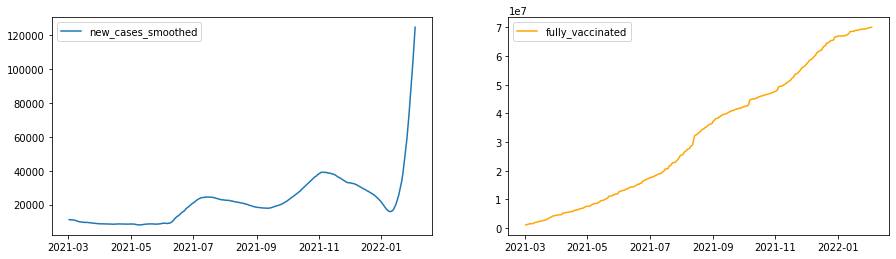

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
ax1, ax2 = axs
ax1.plot(df['new_cases_sm']);
ax1.legend(loc='best', labels=['new_cases_smoothed']);
ax2.plot(df['fully_vaccinated'], color='orange');
ax2.legend(loc='best', labels=['fully_vaccinated']);

In [8]:
# cases = df['new_cases_sm'].values
cases = get_cases(60)['Russia']['history']

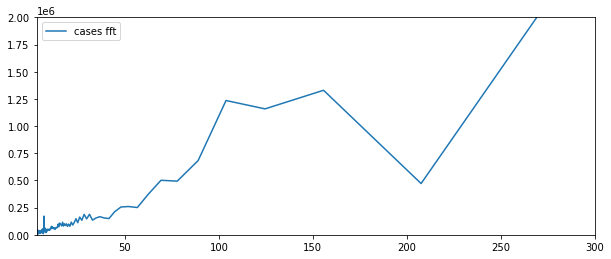

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


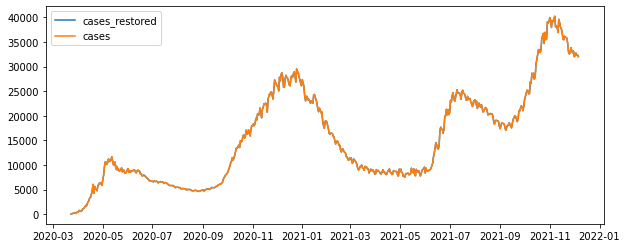

In [18]:
x = cases.index
y = cases.values
n = cases.shape[0]

cases_fft = fft(y) #[1:]
cases_freq = fftfreq(n=n, d=1)
cases_freq[0] = 1/36500 # 1 цикл в 100 лет - просто некоторый большой период
cases_period = 1 / cases_freq
# print(cases_period.shape)
# cases_fft
# assert(cases_rfft.shape == x[1:].shape)
# cases_rfft[np.abs(cases_period - 7) <= 5] *= 0

plt.figure(figsize=(10, 4))
plt.plot(cases_period, np.abs(cases_fft));
ax = plt.gca()
ax.set_ylim((0, 2e6))
ax.set_xlim((3, 300))
ax.legend(loc='upper left', labels=['cases fft'])
plt.show();

plt.figure(figsize=(10, 4))

cases_rest = ifft(cases_fft[:])
plt.plot(x[:cases_rest.shape[0]], cases_rest, label='cases_restored');

plt.plot(x, y, label='cases');
plt.legend(loc='best');

# plt.xticks(pd.date_range(start="2020-04-01", end="2022-02-01", periods=5));


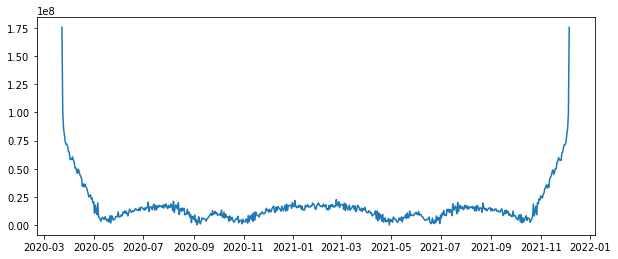

In [65]:
cases_ampls = np.abs(cases_fft).reshape(1, -1)
cases_phases = np.angle(cases_fft).reshape(1, -1)
cases_freq = cases_freq.reshape(1, -1)

t = np.asarray([d.days for d in x - x[0]], dtype=object).reshape(-1, 1)

arg = (t @ cases_freq * 2j * np.pi + cases_phases)
exp = np.asarray([[np.exp(m) for m in k] for k in arg])
cases_harm = np.abs((cases_ampls * exp).sum(axis=1))

plt.figure(figsize=(10, 4));
plt.plot(x, cases_harm);
# cases_ampls.shape, cases_phases.shape, cases_freq.shape, t.shape, cases_harm.shape




array([[ 2.73972603e-05,  1.60513644e-03,  3.21027287e-03,
         4.81540931e-03,  6.42054575e-03,  8.02568218e-03,
         9.63081862e-03,  1.12359551e-02,  1.28410915e-02,
         1.44462279e-02,  1.60513644e-02,  1.76565008e-02,
         1.92616372e-02,  2.08667737e-02,  2.24719101e-02,
         2.40770465e-02,  2.56821830e-02,  2.72873194e-02,
         2.88924559e-02,  3.04975923e-02,  3.21027287e-02,
         3.37078652e-02,  3.53130016e-02,  3.69181380e-02,
         3.85232745e-02,  4.01284109e-02,  4.17335474e-02,
         4.33386838e-02,  4.49438202e-02,  4.65489567e-02,
         4.81540931e-02,  4.97592295e-02,  5.13643660e-02,
         5.29695024e-02,  5.45746388e-02,  5.61797753e-02,
         5.77849117e-02,  5.93900482e-02,  6.09951846e-02,
         6.26003210e-02,  6.42054575e-02,  6.58105939e-02,
         6.74157303e-02,  6.90208668e-02,  7.06260032e-02,
         7.22311396e-02,  7.38362761e-02,  7.54414125e-02,
         7.70465490e-02,  7.86516854e-02,  8.02568218e-0

In [ ]:
cases_ampls[:: -1]

In [ ]:
# (t @ cases_freq).shape
# t.shape, cases_freq.shape

In [ ]:
fft_ = fft(cases)[:]
x = df['new_cases_sm'].index

plt.plot(x, fft_);

ax = plt.gca()
ax.set_ylim((0, 0.6e6))
# ax.set_xlim((0, 0.5))
plt.show();

plt.plot(x, ifft(fft_))